# Synthetic Control Method
Causal analysis of the brexit impact on GDP/capita in UK

## Set up

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (check_X_y, check_array, check_is_fitted)
import cvxpy as cp

# Clean

In [3]:
df = pd.read_csv('assets\gdp_per_capita.csv', sep=',', header=2)
df.shape

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
C:\Users\guill\AppData\Local\Temp\ipykernel_11988\2777245802.py:1: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv('assets\gdp_per_capita.csv', sep=',', header=2)


(266, 69)

In [4]:
# drop colukmns Country Code
df = df.drop(['Country Code', "Indicator Name", "Indicator Code", "Unnamed: 68"], axis=1)
df.head(2)

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36763.209005,37231.918495,37444.441094,38697.949507,40379.293724,40124.757998,30437.202516,38226.146157,45236.021214,NaN
1,Africa Eastern and Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3473.843253,3502.296662,3595.841041,3640.628582,3695.386884,3783.518751,3666.871961,3967.400629,4294.025281,4459.764134


In [5]:
#only select OCDE countries
lst_ocde = oecd_countries = [
    'Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
    'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Latvia',
    'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway',
    'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
    'United Kingdom', 'United States'
]

df = df[df['Country Name'].isin(lst_ocde)]
df.shape

(35, 65)

<Axes: ylabel='Country Name'>

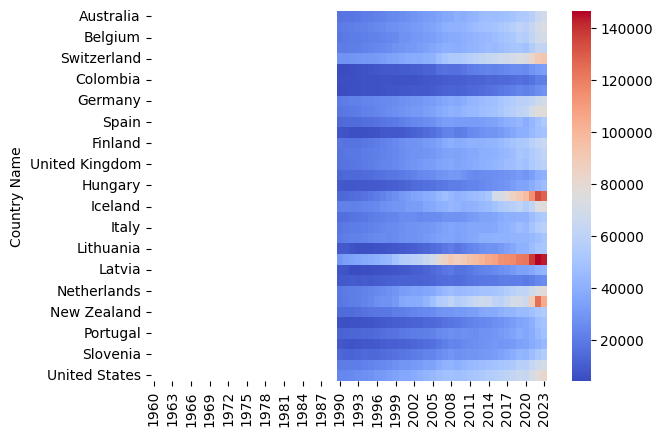

In [6]:
#plot an heatmap of all value
df = df.set_index("Country Name")
sns.heatmap(df, annot=False, cmap='coolwarm', vmax=None, vmin=None)

In [7]:
#drop all columns before 1990
df = df.drop(df.columns[0:31], axis=1)
#no NaN

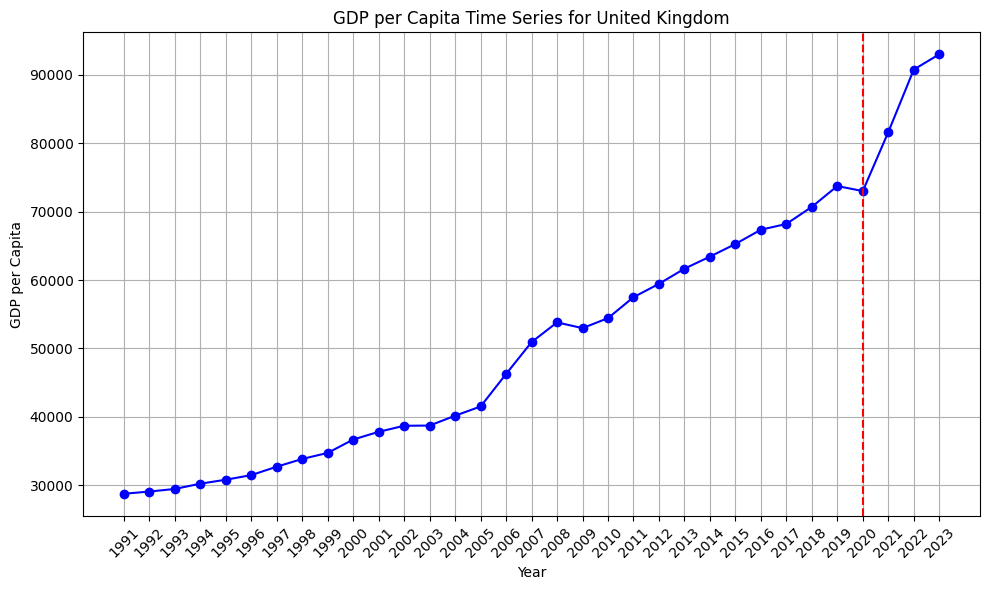

In [103]:
# Select the GDP data for the United Kingdom
uk_gdp = df.loc['United Kingdom']

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(uk_gdp.index, uk_gdp.values, marker='o', linestyle='-', color='b')
plt.title('GDP per Capita Time Series for United Kingdom')
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical line for Brexit (January 31, 2020)
plt.axvline(x='2020', color='r', linestyle='--', label='Brexit')
# Show the plot
plt.show()

# Synthetic Control Method
it should be a matrix like $ 
\begin{bmatrix}
y\_pre\_co & y\_pre\_tr \\  
y\_post\_co & y\_post\_tr \\
\end{bmatrix} $

In [104]:
def reshape_df(df: pd.DataFrame, treated: str, treatment_year: int) -> pd.DataFrame:
    """Input df should be observations X times matrix and observations should be the indexes"""
    #inverse column and rows
    df = df.transpose()

    df.index = df.index.astype(int)
    y_tr = df[treated]
    y_co = df = df.drop(columns=treated)
    y_pre_tr = y_tr[y_tr.index < treatment_year].to_frame()
    y_pre_co = y_co[y_co.index < treatment_year]
    y_post_tr = y_tr[y_tr.index >= treatment_year].to_frame()
    y_post_co = y_co[y_co.index >= treatment_year]



    return y_pre_tr, y_pre_co, y_post_tr, y_post_co

In [105]:
y_pre_tr, y_pre_co, y_post_tr, y_post_co = reshape_df(df=df, treated="United Kingdom", treatment_year=2020)

In [106]:
class SyntheticControl():
    def __init__(self,):
        pass
    def fit(self, y_pre_co, y_pre_tr):

       y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)

       w = cp.Variable(y_pre_co.shape[1])

       objective = cp.Minimize(cp.sum_squares(y_pre_co@w - y_pre_tr))
       constraints = [cp.sum(w) == 1, w >= 0]

       problem = cp.Problem(objective, constraints)

       self.loss_ = problem.solve()
       self.w_ = w.value

       self.is_fitted_ = True
       return self
    
    def predict(self, y_co):

        check_is_fitted(self)
        y_co = check_array(y_co)
        return y_co @ self.w_

In [108]:
model = SyntheticControl()
model.fit(y_pre_co=y_pre_co, y_pre_tr=y_pre_tr.mean(axis=1))

model.w_.round(3)

In [13]:
df_weights = pd.DataFrame(zip(model.w_.round(3), y_pre_co.columns), columns=['weight', 'Coutries'])
df_weights

,weight,Coutries
0,0.043,Australia
1,-0.000,Austria
2,0.000,Belgium
3,0.304,Canada
4,-0.000,Switzerland
5,-0.000,Chile
6,-0.000,Colombia
7,-0.000,Costa Rica
8,-0.000,Germany
9,-0.000,Denmark


In [14]:
y0_tr_hat = y_post_co.dot(model.w_)
y0_tr_hat

2020    48944.065894
2021    55774.952295
2022    63690.712644
2023    63934.674564
dtype: float64

In [15]:
att = y_post_tr.mean(axis=1) - y0_tr_hat
att

2020    -938.186288
2021   -2933.317710
2022   -6929.195345
2023   -5028.435707
dtype: float64

In [16]:
df = df.transpose()
df.index = df.index.astype(int)
treated = df["United Kingdom"]

In [17]:
sc = pd.concat([y_pre_co.dot(model.w_), y0_tr_hat])
result = pd.DataFrame({ "Treated" : treated, "Synthetic Control" : sc})

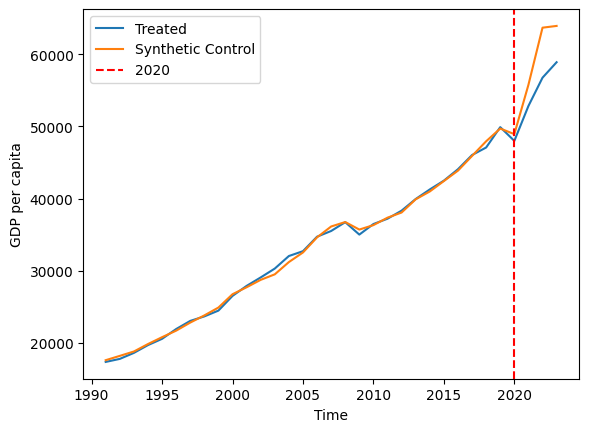

In [18]:
# Plot two lines, one for each column
sns.lineplot(x=result.index, y=result['Treated'], label='Treated')
sns.lineplot(x=result.index, y=result['Synthetic Control'], label='Synthetic Control')

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('GDP per capita')
plt.axvline(x=2020, color='red', linestyle='--', label='2020')
plt.legend()

plt.show()


# Placebo effect

In [25]:
from methods.SCM import analyse
import numpy as np
import pandas as pd
df = pd.read_csv(r'assets\test.csv', sep=',', index_col=0)

In [26]:
def pre_RMSPE_calculation(result: pd.DataFrame, treatment_year: int)-> float:
    delta = result.loc[result.index < treatment_year, "Treated"] /result.loc[result.index < treatment_year, "Synthetic Control"]
    delta_squared = delta ** 2
    sum = delta_squared.sum()
    sum_mutliplied = 1/result.loc[result.index < treatment_year, "Treated"].shape[0]
    pre_RMSPE = np.sqrt(sum_mutliplied * sum)
    return pre_RMSPE

def post_RMSPE_calculation(result: pd.DataFrame, treatment_year: int)-> float:
    delta = result.loc[result.index >= treatment_year, "Treated"] /result.loc[result.index >= treatment_year, "Synthetic Control"]
    delta_squared = delta ** 2
    sum = delta_squared.sum()
    sum_mutliplied = 1/result.loc[result.index < treatment_year, "Treated"].shape[0]
    post_RMSPE = np.sqrt(sum_mutliplied * sum)
    return post_RMSPE

def placebo_calculation(result: pd.DataFrame, treatment_year: int) -> float:
    post_RMSPE = post_RMSPE_calculation(result, treatment_year)
    pre_RMSPE  = pre_RMSPE_calculation(result, treatment_year)
    post_RMSPE_on_pre_RMSPE = post_RMSPE /pre_RMSPE
    return post_RMSPE_on_pre_RMSPE

In [27]:
treatment_year = 2020



In [41]:
#run an analysis with the same treatment year for each of other control
import cvxpy as cp

obs = df.index
obs_with_effect = {}

for i in obs:

    print(i)
    sc, result, att, df_weights = analyse(df=df, treated=i, treatment_year=treatment_year)
    if sc == "a":
        continue
    post_RMSPE_on_pre_RMSPE = placebo_calculation(result, treatment_year)
    obs_with_effect[i] = post_RMSPE_on_pre_RMSPE

    
    

# Extract keys and values
keys = list(obs_with_effect.keys())  # These will be on the y-axis
values = list(obs_with_effect.values())  # These will be on the x-axis

# Create the plot
plt.figure(figsize=(8, 6))
plt.barh(keys, values)  # Use barh for a horizontal bar plot

# Add labels
plt.xlabel('post-treatment RMSPE / pre-treatment RMSPE')
plt.ylabel('Observations in the pool')
plt.title('Placebo effect')

# Show the plot
plt.show()

Australia


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
for i in obs:
    try:
        print(i)
        sc, result, att, df_weights = analyse(df=df, treated=i, treatment_year=treatment_year)
        
        if sc is None:
            continue

        post_RMSPE_on_pre_RMSPE = placebo_calculation(result, treatment_year)
        obs_with_effect[i] = post_RMSPE_on_pre_RMSPE

    except (AttributeError, SolverError) as e:
        print(f"Error with {i}: {e}")
        continue


# Test

In [1]:
from fun import analyse
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (check_X_y, check_array, check_is_fitted)
import cvxpy as cp

treated = "United Kingdom"
treatment_year = 2020
df = pd.read_csv('assets\gdp_per_capita.csv', sep=',', header=2)
df = df.drop(['Country Code', "Indicator Name", "Indicator Code", "Unnamed: 68"], axis=1)
lst_ocde = oecd_countries = [
    'Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
    'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Latvia',
    'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway',
    'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
    'United Kingdom', 'United States'
]

df = df[df['Country Name'].isin(lst_ocde)]
df = df.set_index("Country Name")
df = df.drop(df.columns[0:31], axis=1)



sc, result, att, df_weights = analyse(df=df, treated=treated, treatment_year=treatment_year)

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
C:\Users\guill\AppData\Local\Temp\ipykernel_32136\317779742.py:9: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv('assets\gdp_per_capita.csv', sep=',', header=2)


In [15]:
import pandas as pd
df = pd.read_csv('assets\gdp_per_capita.csv', sep=',', header=2)

df = df.drop(['Country Code', "Indicator Name", "Indicator Code", "Unnamed: 68"], axis=1)
lst_ocde = oecd_countries = [
    'Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
    'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Latvia',
    'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway',
    'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
    'United Kingdom', 'United States'
]

df = df[df['Country Name'].isin(lst_ocde)]
df = df.set_index("Country Name")
df = df.drop(df.columns[0:31], axis=1)

# df.to_csv(r'assets\test.csv', index=True)

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\guill\AppData\Local\Temp\ipykernel_12564\3811187923.py:2: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv('assets\gdp_per_capita.csv', sep=',', header=2)


In [14]:
df = pd.read_csv(r"assets\test.csv", sep=",", index_col=0)
df

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Country Name,,,,,,,,,,,,,,,,,,,,,
Australia,17835.358077,18253.581635,19215.960587,20170.525398,21038.666785,22132.192903,23124.963912,24378.245311,25485.391446,26541.665321,...,46914.386708,46292.095439,47289.285914,48418.558422,50251.335338,52746.718290,54064.079466,57406.178760,65365.948511,69114.737895
Austria,20602.884232,21278.100843,21717.382709,22626.699944,23681.212326,24552.026477,25422.023289,26674.840805,27606.483030,29379.742297,...,48799.715468,49865.903942,52684.017113,54172.986789,56937.944283,60574.627103,58610.834364,63421.203587,70975.720635,73751.352706
Belgium,19587.855350,20258.547446,20459.189148,21504.011774,22431.459360,22736.758069,23727.897521,24368.757409,25440.841189,27788.090883,...,44929.685593,46200.904454,48597.399983,50442.270542,52530.562082,56621.541761,55730.952894,62123.161317,68274.200642,70455.958426
Canada,20224.687331,20626.202059,21440.046986,22632.834086,23485.641928,24050.175006,25258.860560,26319.674164,27841.353350,29362.084161,...,45758.100730,44668.091281,46470.646639,48317.387446,49982.599912,50498.973106,48590.683212,55781.699027,62041.562030,61582.349971
Switzerland,28773.013936,29093.323854,29475.750052,30245.375967,30821.437052,31497.741957,32728.011422,33857.653168,34742.631863,36695.207055,...,63417.043716,65265.045734,67350.751875,68193.505494,70688.818749,73732.235332,72997.823950,81603.207307,90746.453279,92980.401876
Chile,4872.139688,5533.632681,6026.750096,6473.886967,7250.188762,7959.485754,8581.436492,8927.836442,8921.986048,9468.318766,...,22779.427670,22691.486624,23492.287857,24546.912421,25564.536717,25824.646525,25443.214015,29050.080794,31586.136898,33284.494734
Colombia,5253.121214,5480.393726,5797.020829,6144.241805,6475.643906,6608.062186,6829.668083,6826.340936,6521.790900,6754.297331,...,13323.169084,13289.674489,13971.339588,14334.914608,15161.317974,16091.499048,15427.593781,17587.231793,21055.663030,21548.013369
Costa Rica,5115.148147,5571.163454,5958.338269,6207.841612,6446.625147,6501.576463,6820.684649,7232.272837,7487.001659,7797.391995,...,16132.657876,17248.747397,18898.075223,20168.220481,21144.409774,22949.528659,21716.870243,23700.296131,26181.142017,27952.476624
Germany,20981.206455,21706.353961,21859.634446,22781.300572,23548.834125,24070.119235,24568.142891,25344.881319,26291.211079,27202.476085,...,47011.551094,47609.781005,50579.683930,53071.455570,55195.840543,58251.773083,57905.179551,61939.651585,66616.022245,69338.293226
